# **CS224W - Colab 1**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scpd-proed/XCS224W-Colab1/blob/main/Notebook/XCS224W_Colab1.ipynb)

Before opening the colab with the badge, you would need to allow Google Colab to access the GitHub private repositories. Please check therefore [this tutorial](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#:~:text=Navigate%20to%20http%3A%2F%2Fcolab,to%20read%20the%20private%20files.).

If colab is opened with this badge, make sure please **save copy to drive** in 'File' menu before running the notebook.

In this Colab, you will write a pipeline for **learning node embeddings** in a graph. You will go through the following 3 steps:

1.   To start, you will load the familiar [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) from Colab 0. You will explore multiple graph statistics over this graph.
2.   You will then work to transform the graph structure into a PyTorch tensor so that you can perform machine learning over the graph.

3. Finally, you will write your first graph learning algorithm: a node embedding model. For simplicity, your model is simpler than the DeepWalk and node2vec algorithms taught in Module 1, Unit 1.2 - Node Embeddings. Nevertheless, it will still be rewarding and challenging, as you will write the whole procedure from scratch via PyTorch.

Let's get started!

**Note**: Make sure to **sequentially run all the cells** so that the intermediate variables / packages will carry over to the next cell

## Building + Debugging Notes
While working through this Colab and future Colabs, we strongly encourage you to follow a couple of building / debugging strategies:
- During debugging make sure to run your notebook using the CPU runtime. You can change the notebook runtime by selecting `Runtime` and then `Change runtime type`. From the dropdown, select `None` as the `hardware accelerator`.
- When working with PyTorch and Neural Network models, understanding the shapes of different tensors, especially the input and output tensors is incredibly helpful.
- When training models, it is helpful to start by only running 1 epoch or even just a couple of batch iterations. This way you can check that all your tensor shapes and logic match up, while also tracking expected behavior, such as a decreasing training loss. Remember to comment out / save the default number of epochs that we provide you.


# 1) Graph Basics
To start, load the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club), a classical graph in network science. As discussed in the introduction, you will begin by exploring multiple graph statistics for this graph.

## Setup
As introduced in Colab 0, NetworkX is a powerful package for storing and manipulating graphs. We will heavily rely on NetworkX throughout this Colab.

In [1]:
import networkx as nx
import os

## Zachary's karate club network

The [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a social network graph of 34 members of a karate club, where links exist between members who have interacted outside the club.

In [2]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

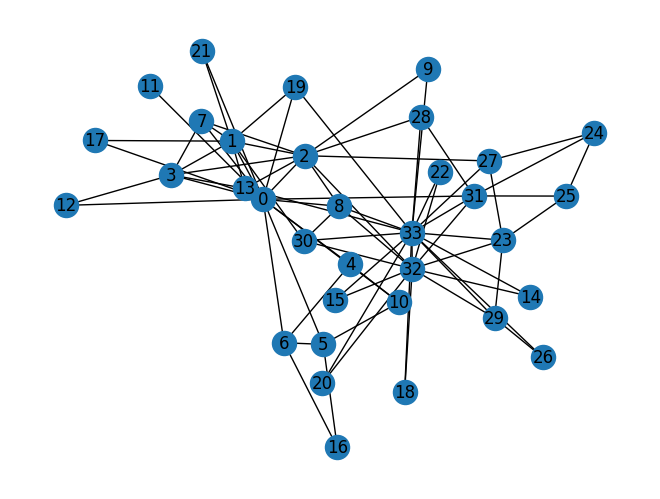

In [3]:
# Visualize the graph
if 'IS_GRADESCOPE_ENV' not in os.environ:
  nx.draw(G, with_labels = True)

## Question 1: What is the average degree of the karate club network? (1 Points)

In [4]:
def average_degree(num_edges, num_nodes):
  # Average degree in an undirected graph is 2 * (number of edges) / (number of nodes)
  avg_degree = 2 * num_edges / num_nodes
  # Round to nearest integer as required
  avg_degree = round(avg_degree)
  return avg_degree

if 'IS_GRADESCOPE_ENV' not in os.environ:
  num_edges = G.number_of_edges()
  num_nodes = G.number_of_nodes()
  avg_degree = average_degree(num_edges, num_nodes)
  print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


## Question 2: What is the average clustering coefficient of the karate club network? (1 Points)

In [5]:
def average_clustering_coefficient(G):
  # Using NetworkX's average_clustering function to directly calculate
  # the average clustering coefficient for all nodes in the graph
  avg_cluster_coef = nx.average_clustering(G)
  
  # Round to 2 decimal places as required
  avg_cluster_coef = round(avg_cluster_coef, 2)
  
  return avg_cluster_coef

if 'IS_GRADESCOPE_ENV' not in os.environ:
  avg_cluster_coef = average_clustering_coefficient(G)
  print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.57


## Question 3: What is the PageRank value for node 0 (node with id 0) after one PageRank iteration? (5 Points)

Please complete the code block by implementing the PageRank equation: $r_j^{t+1} = [\sum_{i \rightarrow j} \beta \frac{r_i^t}{d_i}] + (1 - \beta) \frac{1}{N}$ to update the PageRank value of an arbitrary node j for the first time step $t = 0 \rightarrow t = 1$.

**NOTE:** $r_j^0 = 1 / |N|$ for all nodes j (where $N$ is the number of nodes in the graph). Namely, at $t=0$ every node is initialized with the same PageRank value.

In [6]:
def one_iter_pagerank(G, beta, r0, node_id):
  # Initialize the PageRank value
  rj_1 = 0
  
  # Sum contributions from all neighbors (in an undirected graph,
  # all neighbors are "incoming" nodes)
  for neighbor in G.neighbors(node_id):
    # Each neighbor contributes (beta * r0 / degree)
    neighbor_degree = G.degree(neighbor)
    rj_1 += beta * (r0 / neighbor_degree)
  
  # Add the teleportation component
  rj_1 += (1 - beta) * (1 / G.number_of_nodes())
  
  # Round to 2 decimal places
  rj_1 = round(rj_1, 2)
  
  return rj_1

if 'IS_GRADESCOPE_ENV' not in os.environ:
  beta = 0.8
  r0 = 1 / G.number_of_nodes()
  node = 0
  r0_1 = one_iter_pagerank(G, beta, r0, node)
  print("The PageRank value for node 0 after one iteration is {}".format(r0_1))

The PageRank value for node 0 after one iteration is 0.13


## Question 4: What is the (raw) closeness centrality for the node with id=5 in the karate club network? (1 Points)

The equation for closeness centrality is $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$. Remember that we want the raw (unnormalized) closeness centrality from Module 1, Unit 1.1 - Traditional Feature Based Methods.

In [7]:
def closeness_centrality(G, node=5):
   # Get all shortest path lengths from the specified node to all other nodes
   # Returns a dictionary where keys are target nodes and values are path lengths
   path_lengths = nx.single_source_shortest_path_length(G, node)
   
   # Calculate the sum of all distances from the node to all other nodes
   # We exclude the node itself from the calculation (which would have distance 0)
   total_distance = sum([length for target, length in path_lengths.items() if target != node])
   
   # Calculate raw closeness centrality using the formula:
   # c(v) = 1 / sum of shortest paths from v to all other nodes
   # We include a safeguard against division by zero (though this shouldn't happen in a connected graph)
   closeness = 1 / total_distance if total_distance > 0 else 0
   
   # Round the result to 2 decimal places as required by the assignment
   return round(closeness, 2)

if 'IS_GRADESCOPE_ENV' not in os.environ:
  node = 5
  closeness = closeness_centrality(G, node=node)
  print("The karate club network has closeness centrality {}".format(closeness))

The karate club network has closeness centrality 0.01


# 2) Graph to Tensor
Now, you will work to transform the graph $G$ into a PyTorch tensor, so that you can perform machine learning over the graph.

## Setup
Check if PyTorch is properly installed

In [8]:
import torch
print(torch.__version__)

2.5.1+cu124


## PyTorch tensor basics

Generate PyTorch tensor with all zeros, ones or random values.

In [9]:
# Generate 3 x 4 tensor with all ones
ones = torch.ones(3, 4)
print(ones)

# Generate 3 x 4 tensor with all zeros
zeros = torch.zeros(3, 4)
print(zeros)

# Generate 3 x 4 tensor with random values on the interval [0, 1)
random_tensor = torch.rand(3, 4)
print(random_tensor)

# Get the shape of the tensor
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.9874, 0.9282, 0.9317, 0.8626],
        [0.5916, 0.6921, 0.9353, 0.4569],
        [0.4848, 0.7759, 0.6051, 0.6525]])
torch.Size([3, 4])


PyTorch tensors contains elements for a single data type, the `dtype`.

In [10]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


## Question 5: Get the edge list of the karate club network and transform it into `torch.LongTensor`. What is the `torch.sum` value of the `pos_edge_index` tensor? (2 Points)

In [11]:
def graph_to_edge_list(G):
  # NetworkX provides a simple function to get all edges as tuples
  # Each edge is represented as (source_node, target_node)
  # For undirected graphs, each edge appears only once
  edge_list = list(G.edges())
  
  return edge_list

def edge_list_to_tensor(edge_list):
  # Create empty lists for source and target nodes
  sources = []
  targets = []
  
  # Extract source and target nodes from each edge tuple
  for edge in edge_list:
      sources.append(edge[0])
      targets.append(edge[1])
  
  # Stack the lists to create a tensor of shape [2, num_edges]
  # First row contains all source nodes, second row contains all target nodes
  edge_index = torch.tensor([sources, targets], dtype=torch.long)

  return edge_index

if 'IS_GRADESCOPE_ENV' not in os.environ:
  pos_edge_list = graph_to_edge_list(G)
  pos_edge_index = edge_list_to_tensor(pos_edge_list)
  print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
  print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## Question 6: Implement a function that samples negative edges. A negative edge exists between nodes $u$ and $v$ if there is no edge between $u$ and $v$ in the original graph.

## Then, write a short function to answer which edges (edge_1 - edge_5) can be negative edges in the karate club network? (7.5 Points)

In [12]:
import random

def sample_negative_edges(G, num_neg_samples):
  # Set the random seed for reproducibility
  random.seed(1)
  
  # Create a list to store negative edges
  neg_edge_list = []
  
  # Get the total number of nodes in the graph
  num_nodes = G.number_of_nodes()
  
  # Keep sampling until we have enough negative edges
  while len(neg_edge_list) < num_neg_samples:
      # Randomly select two nodes
      u = random.randint(0, num_nodes-1)
      v = random.randint(0, num_nodes-1)
      
      # Skip if it's a self-loop (u == v)
      if u == v:
          continue
      
      # Skip if the edge already exists in the graph
      if G.has_edge(u, v):
          continue
      
      # Skip if we've already added this negative edge
      if (u, v) in neg_edge_list or (v, u) in neg_edge_list:
          continue
      
      # Add the negative edge to our list
      neg_edge_list.append((u, v))

  return neg_edge_list

def check_negative_edge(G, edge):
  # An edge is negative if it doesn't exist in the graph
  # For undirected graphs, we need to check both directions
  u, v = edge
  
  # Skip self-loops - they're neither positive nor negative edges
  if u == v:
      return False
  
  # Check if the edge exists in the graph (in either direction)
  is_negative_edge = not G.has_edge(u, v)
  
  return is_negative_edge

if 'IS_GRADESCOPE_ENV' not in os.environ:
  # Sample 78 negative edges
  neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

  # Transform the negative edge list to tensor
  neg_edge_index = edge_list_to_tensor(neg_edge_list)
  print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

  # Which of following edges can be negative ones?
  edge_1 = (7, 1)
  edge_2 = (1, 33)
  edge_3 = (33, 22)
  edge_4 = (0, 4)
  edge_5 = (4, 2)

  for u, v in [edge_1, edge_2, edge_3, edge_4, edge_5]:
    print ((u, v), check_negative_edge(G, (u, v)))


The neg_edge_index tensor has shape torch.Size([2, 78])
(7, 1) False
(1, 33) True
(33, 22) False
(0, 4) False
(4, 2) True


# 3) Node Embedding Learning

Finally, you write your first learning algorithm on graphs: **a node embedding model**.


## Setup

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

2.5.1+cu124


To write your node embedding model, you will heavily utilize the [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module in PyTorch. Let us first explore how to use `nn.Embedding`:

In [14]:
# Initialize an embedding layer.
# Suppose you want to have embedding for 4 items (e.g., nodes).
# Each item is represented by an 8 dimensional vector.

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


You can select items from the embedding matrix by using Tensor indices.

In [15]:
# Select an embedding in emb_sample
node_id = torch.LongTensor([1])
print(emb_sample(node_id))

# Select multiple embeddings
node_ids = torch.LongTensor([1, 3])
print(emb_sample(node_ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initialized
node_ids = torch.LongTensor([0, 3])
print(emb_sample(node_ids))

tensor([[-3.9410e-02, -6.8799e-01,  1.3746e+00,  9.6013e-01, -1.8199e+00,
          6.0118e-01,  2.7014e-04, -2.9729e-01]], grad_fn=<EmbeddingBackward0>)
tensor([[-3.9410e-02, -6.8799e-01,  1.3746e+00,  9.6013e-01, -1.8199e+00,
          6.0118e-01,  2.7014e-04, -2.9729e-01],
        [ 6.6947e-01,  1.4075e+00, -6.2647e-01,  1.4049e+00, -4.0402e-01,
          2.0532e-02, -9.1932e-01,  6.1278e-01]], grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


Now, it's time to create a node embedding matrix for our graph!
- Each node in the karate club network is represented by a **16 dimensional** vector.
- Initalize the matrix using a **uniform distribution**, in the range of $[0, 1)$. We suggest using [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

## Question 7: Implement a function creating the node embedding matrix. (2.5 Points)

In [17]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
  # Create an embedding layer with specified dimensions
  # num_node: number of nodes in the graph
  # embedding_dim: dimension of each node's embedding vector
  emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)
  
  # Initialize the embedding weights with random values from uniform distribution [0,1)
  # This replaces the default initialization in PyTorch
  emb.weight.data = torch.rand(num_node, embedding_dim)

  return emb

if 'IS_GRADESCOPE_ENV' not in os.environ:
  emb = create_node_emb()
  node_ids = torch.LongTensor([0, 3])

  # Print the embedding layer
  print("Embedding: {}".format(emb))

  # An example that gets the embeddings for node 0 and 3
  print(emb(node_ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


## Visualize the initial node embeddings
One good way to understand an embedding matrix, is to visualize it in a 2D space.
Here, we have implemented an embedding visualization function for you.
We first do PCA to reduce the dimensionality of embeddings to a 2D space.
Then, we visualize each point, colored by the community it belongs to.

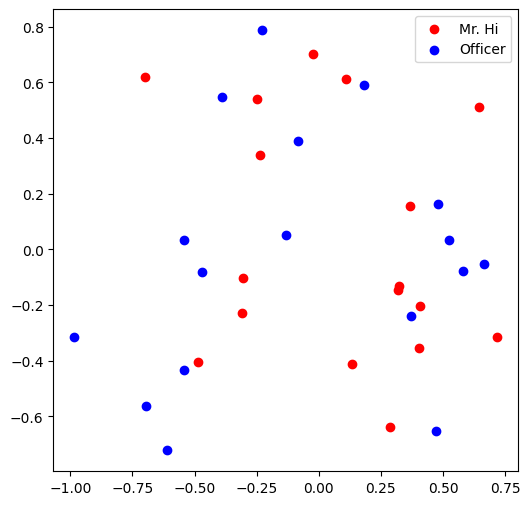

In [18]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
if 'IS_GRADESCOPE_ENV' not in os.environ:
  visualize_emb(emb)

## Question 8: Train your first embedding model by maximizing the dot product between positive edge node pairs and minimizng the dot product between negative edge node pairs in the graph. Through training see the best performance that you can get! You should experiment with changing a few of the hyper parameters to observe the effect on training. (10.0 Points)

**NOTE**: There is no need to heavily hyper-parameter tune your model! We ask you to explore updating a couple of hyper-parameters primarily to explore their potential effects. 


In [19]:
class EmbModel(torch.nn.Module):
    def __init__(self, emb, sigmoid):
 
        super(EmbModel, self).__init__()

        # The node embedding matrix
        self.emb = emb

        # The sigmoid to be applied in the forward pass
        self.sigmoid = sigmoid

    def forward(self, train_edge):
        # train_edge: shape [2, num_edges]
        u_nodes = train_edge[0]     # Source nodes of edges
        v_nodes = train_edge[1]     # Target nodes of edges

        # Get embeddings for source and target nodes
        u_emb = self.emb(u_nodes)   # shape: [num_edges, embedding_dim]
        v_emb = self.emb(v_nodes)   # same shape

        # Compute dot product between each pair of embeddings
        dot_prod = torch.sum(u_emb * v_emb, dim=1)  # shape: [num_edges]

        # Pass through sigmoid to get probabilities
        out = self.sigmoid(dot_prod)
        
        return out

In [20]:
from torch.optim import SGD

def accuracy(pred, label):
    # Convert probabilities to binary predictions using threshold 0.5
    binary_pred = (pred > 0.5).float()

    # Compute correct predictions
    correct = (binary_pred == label).sum().item()

    # Accuracy = correct predictions / total predictions
    accu = round(correct / len(label), 4)

    return accu

def train(model, loss_fn, train_label, train_edge):
  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for epoch in range(epochs):
          model.train()

          # Forward pass: get predictions
          pred = model(train_edge)

          # Compute loss
          loss = loss_fn(pred, train_label)

          # Compute accuracy
          acc = accuracy(pred, train_label)

          # Backward pass
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Print loss and accuracy every 50 epochs
          if epoch % 50 == 0:
              print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")

if 'IS_GRADESCOPE_ENV' not in os.environ:
  loss_fn = nn.BCELoss()
  sigmoid = nn.Sigmoid()

  # Generate the positive and negative labels
  pos_label = torch.ones(pos_edge_index.shape[1], )
  neg_label = torch.zeros(neg_edge_index.shape[1], )

  # Concat positive and negative labels into one tensor
  train_label = torch.cat([pos_label, neg_label], dim=0)

  # Concat positive and negative edges into one tensor
  # Since the network is very small, we do not split the edges into val/test sets
  train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
  print (train_edge)

  model = EmbModel(emb, sigmoid)

  train(model, loss_fn, train_label, train_edge)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  4,
          4,  5,  5,  5,  6,  8,  8,  8,  9, 13, 14, 14, 15, 15, 18, 18, 19, 20,
         20, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 26, 26, 27, 28, 28, 29,
         29, 30, 30, 31, 31, 32,  8, 16, 30, 13, 31,  0, 17,  6, 24, 27, 14, 29,
          1,  6, 18, 21, 27, 12, 18, 32,  2, 15, 26,  5, 32, 10, 19, 14, 22, 24,
         13,  3, 23, 32, 31, 26, 29, 14, 11, 16,  4,  1, 15,  7, 22, 10, 17, 29,
         31, 19, 21, 12, 32, 14, 25,  2, 28, 27,  1, 20,  3,  8, 10, 16, 13, 10,
          2, 12, 27, 31, 24,  1, 25,  1, 12,  8, 17, 24],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  2,  3,
          7, 13, 17, 19, 21, 30,  3,  7,  8,  9, 13, 27, 28, 32,  7, 12, 13,  6,
         10,  6, 10, 16, 16, 30, 32, 33, 33, 33, 32, 33, 32, 33, 32, 33, 33, 32,
         33, 32, 33, 25, 27, 29, 32, 33, 25, 27, 31

## **Saving Your Model Predictions**!
After you have successfully trained your embedding model, run the cell below to save your model's predictions on the training data. The function below will generate and save a csv file called *model_predictions.csv* to the local Colab files folder. This folder can be accessed by clicking the *Folder* icon on the left panel underneath the *Table of contents*, *Find and replace*, and *Code snippets* icons. 

When submitting this Colab you will have to download your model's predictions and submit them along with your Colab ipython notebook.

In [21]:
import pandas as pd
import numpy as np

def save_model_results(emb_model, train_label, train_edge):
  """
    Helper function to save the model predictions and data
    labels to a csv file for submission.
  """

  # Generate model predictions
  pred = emb_model(train_edge).detach()

  # Create a pandas datafram with columns
  # model_pred | binary_pred | label
  data = {}
  data['model_pred'] = pred
  data['binary_pred'] = np.where(pred > 0.5, 1.0, 0.0)
  data['label'] = train_label.detach()

  df = pd.DataFrame(data=data)
  # Save to csv
  df.to_csv('model_predictions.csv', sep=',', index=False)

if 'IS_GRADESCOPE_ENV' not in os.environ:
  save_model_results(model, train_label, train_edge)

## Visualize the final node embeddings
Now you can visually compare our embeddings with the embeddings before training. After training, you should oberserve that the two classes are more evidently separated. Note that since we are reducing the dimensionality of our embeddings from **16 --> 2** you may not see perfect linear separation.


Overall, visualizing model / node embeddings is a great sanity check for your implementation, in addition to tracking the model's accuracy. 

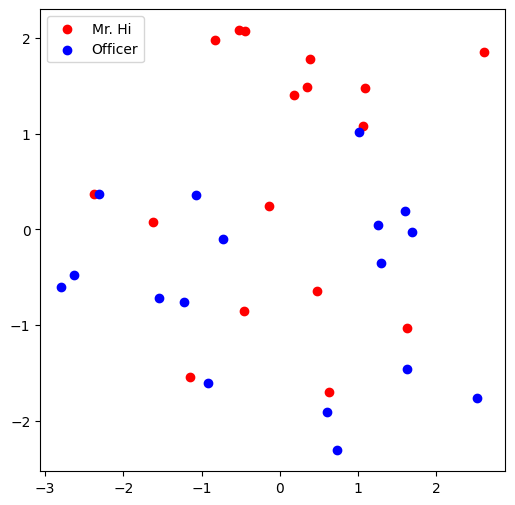

In [22]:
# Visualize the final learned embedding
if 'IS_GRADESCOPE_ENV' not in os.environ:
  visualize_emb(emb)

# Submission

You will need to submit two files on Gradescope to complete this notebook. 

1.   Your completed *XCS224W_Colab1.ipynb*. From the "File" menu select "Download .ipynb" to save a local copy of your completed Colab. 
2.   Your model predictions. Open up the local Colab file folder (by selecting the Folder icon on the left panel) and download *model_predictions.csv* 

For submitting your work, zip the files downloaded in steps 1 and 2 above and submit to gradescope. **NOTE:** DO NOT rename any of the downloaded files. The file names should be *XCS224W_Colab1.ipynb* and *model_predictions.csv*.

